In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys, os
import pandas as pd
from pandas import DataFrame
import datetime
import numpy as np 
import scipy as sc
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold,cross_val_score, learning_curve, cross_validate,train_test_split,GridSearchCV 
from sklearn.feature_selection import RFE, RFECV 
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

In [2]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Columns: 136 entries, AF5 to DPB10w
dtypes: float64(125), int64(6), object(5)
memory usage: 4.7+ MB


In [3]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    teams_code = team_code.copy()
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)
    
    form_code = df.HF5.unique()
    form_code2 = df.AF5.unique()
    form_code = np.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF5'] = to_code['HF5']
    df['AF5'] = to_code['AF5']

    return df,teams_code

df,teams_code = code_string_values(df)

In [5]:
df_copy = df.copy()

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

In [6]:
def normalize(df):
    colums_to_normalization = list(df.columns.values)
    df[colums_to_normalization] = df[colums_to_normalization].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    return df

Optimal number of features: 2
Selected features: ['DP38', 'LSTPD']
LogisticRegression average accuracy for cross-validation test set is 0.526


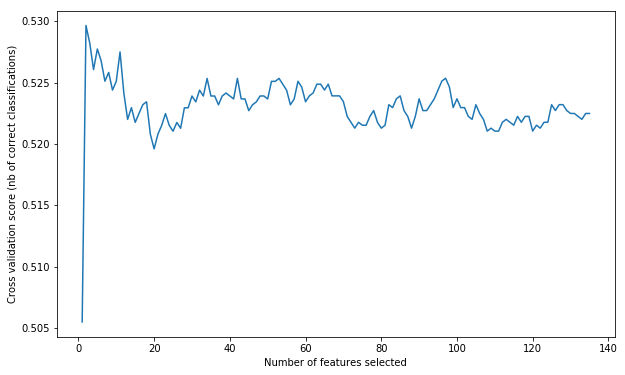

In [7]:
X = X_train.copy()
y = y_train.copy()
X = normalize(X)

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [8]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l2'], 'solver': ['liblinear'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=10)
model_lr.fit(X, y)
clf = model_lr.best_estimator_
print('The best found score and model:')
print (model_lr.best_score_, model_lr.best_params_) 

The best found score and model:
0.5289473684210526 {'C': 10, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}


In [9]:
df_copy = df.copy()

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = normalize(df_copy[df_copy.columns.difference(['FTR'])])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

In [10]:
classifier = LogisticRegression(C= 10,penalty= 'l2',class_weight= None, multi_class= 'multinomial',solver= 'newton-cg') 
classifier = classifier.fit(X_train,y_train)
print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

Accuracy of logistic regression classifier on test validation set: 0.534
Accuracy of logistic regression classifier on train set: 0.528

 Confusion matrix: 
[[ 57   0  51]
 [ 28   0  71]
 [ 27   0 146]] 

Classification report: 
              precision    recall  f1-score   support

           A       0.51      0.53      0.52       108
           D       0.00      0.00      0.00        99
           H       0.54      0.84      0.66       173

   micro avg       0.53      0.53      0.53       380
   macro avg       0.35      0.46      0.39       380
weighted avg       0.39      0.53      0.45       380



<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

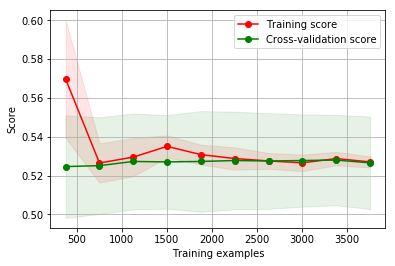

In [11]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve(LogisticRegression(C= 1,penalty= 'l1',class_weight= None, multi_class= 'ovr',solver= 'saga') , X_train, y_train )

In [55]:
df_copy = df.copy()

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

In [56]:
classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.519


Optimal number of features: 17
Selected features: ['AF5', 'AGD5w', 'AGL30w', 'AP30w', 'AwayTeam', 'DP20w', 'DP38', 'DP5w', 'DPB10w', 'DPB20w', 'GD30w', 'HF5', 'HGD20w', 'HGS38w', 'HP10', 'HomeTeam', 'LSTPD']
Ranking [  1  88  60  81  40  12 104  69  93  63   1  91  28  70  96  25   1 119
  89  58  21  62  23  16  19  42  56 100  34  99  46  84  52 106 108 113
 114  78   2  97  30  33   1  92   6  35  17   1  22  31  36   1  54   8
   1  24  85   1  49   1  95   1 118  47 117 115  26   5  27  18  44   7
  53  20  76   1  94  38  10  65   1  48  41  75   1  73  14 103  86  43
  72  80  15 105  39  83  50  51  61 102   3  87  37 110  45  79  71 112
   1 109  57  29 101 111 107  59 116   1  64  55  90  82   4  98  32  74
  11   1  66  13   1   9  67  77  68]
XGBClassifier average accuracy for cross-validation test set is 0.523


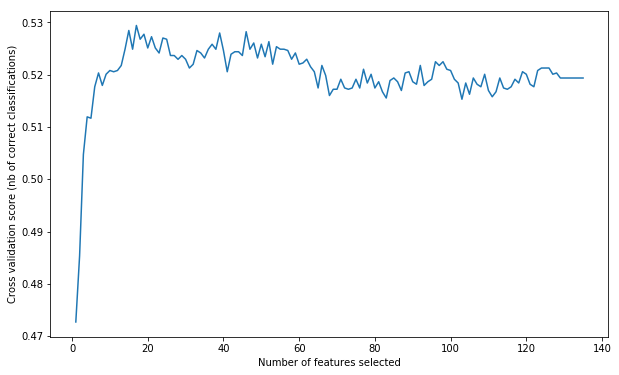

In [57]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), cv=10, scoring='accuracy', n_jobs=-1)
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
print("Ranking %s"%rfecv.ranking_)

rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [7]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(nthread =-1)
fit_params={'early_stopping_rounds': 10, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.529


In [8]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


parameters = {  
    "min_child_weight": st.randint(0, 20),
    "gamma": st.randint(0, 10),
    "subsample": st.beta(10, 1),
    "colsample_bytree": st.beta(10, 1),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.5)
}

fit_params={'early_stopping_rounds':20, 
            'eval_set': [[X, y]]}


classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    gs = RandomizedSearchCV(classifier,param_distributions =parameters,fit_params=fit_params,cv=10,n_jobs=-1,n_iter=250, verbose=10)  
    gs.fit(X, y)  
    
print (gs.best_score_, gs.best_params_) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

0.5342105263157895 {'colsample_bytree': 0.9946873453538718, 'gamma': 6, 'learning_rate': 0.0872881726384608, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9438666971191386}


In [9]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.534


In [58]:
df_copy = df.copy()

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

In [11]:
classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.461722
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.461962
[2]	validation_0-merror:0.461962
[3]	validation_0-merror:0.458134
[4]	validation_0-merror:0.457655
[5]	validation_0-merror:0.458612
[6]	validation_0-merror:0.459569
[7]	validation_0-merror:0.457416
[8]	validation_0-merror:0.458852
[9]	validation_0-merror:0.457177
[10]	validation_0-merror:0.457416
[11]	validation_0-merror:0.457177
[12]	validation_0-merror:0.45622
[13]	validation_0-merror:0.456938
[14]	validation_0-merror:0.457177
[15]	validation_0-merror:0.457895
[16]	validation_0-merror:0.457895
[17]	validation_0-merror:0.458612
[18]	validation_0-merror:0.457655
[19]	validation_0-merror:0.457655
[20]	validation_0-merror:0.457177
[21]	validation_0-merror:0.456938
[22]	validation_0-merror:0.457177
[23]	validation_0-merror:0.455981
[24]	validation_0-merror:0.457177
[25]	validation_0-merror:0.456459
[26]	validation_0-merror:0.456459
[27]	validation_0-merror:0

[0]	validation_0-merror:0.461722	validation_1-merror:0.468421
[1]	validation_0-merror:0.461962	validation_1-merror:0.468421
[2]	validation_0-merror:0.461962	validation_1-merror:0.468421
[3]	validation_0-merror:0.458134	validation_1-merror:0.465789
[4]	validation_0-merror:0.457655	validation_1-merror:0.468421
[5]	validation_0-merror:0.458612	validation_1-merror:0.460526
[6]	validation_0-merror:0.459569	validation_1-merror:0.463158
[7]	validation_0-merror:0.457416	validation_1-merror:0.465789
[8]	validation_0-merror:0.458852	validation_1-merror:0.465789
[9]	validation_0-merror:0.457177	validation_1-merror:0.465789
[10]	validation_0-merror:0.457416	validation_1-merror:0.460526
[11]	validation_0-merror:0.457177	validation_1-merror:0.460526
[12]	validation_0-merror:0.45622	validation_1-merror:0.457895
[13]	validation_0-merror:0.456938	validation_1-merror:0.460526
[14]	validation_0-merror:0.457177	validation_1-merror:0.460526
[15]	validation_0-merror:0.457895	validation_1-merror:0.460526
[16

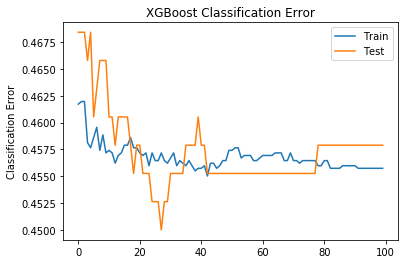

In [12]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

[0]	validation_0-merror:0.45622
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.456459
[2]	validation_0-merror:0.455502
[3]	validation_0-merror:0.457895
[4]	validation_0-merror:0.456938
[5]	validation_0-merror:0.457416
[6]	validation_0-merror:0.456699
[7]	validation_0-merror:0.455981
[8]	validation_0-merror:0.456699
[9]	validation_0-merror:0.458134
[10]	validation_0-merror:0.457895
[11]	validation_0-merror:0.459091
[12]	validation_0-merror:0.460048
Stopping. Best iteration:
[2]	validation_0-merror:0.455502



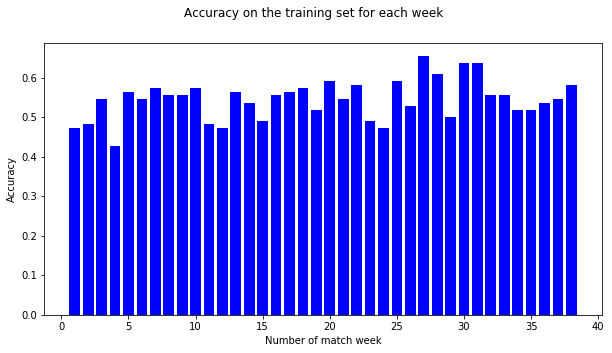

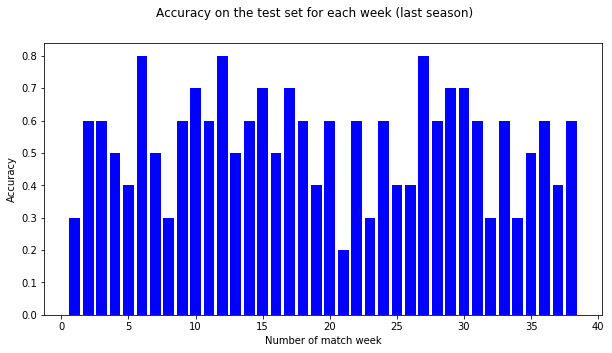

In [59]:
df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.991855704176251, gamma= 7, min_child_weight= 16, 
                               colsample_bytree= 0.9673366090661392, max_depth= 4,learning_rate=0.1312201902337093,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_copy1[df_copy1.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Accuracy on the training set for each week')
plt.xlabel('Number of match week')
plt.ylabel('Accuracy')
plt.show()
    
weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_test[df_test.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Accuracy on the test set for each week (last season)')
plt.xlabel('Number of match week')
plt.ylabel('Accuracy')
plt.show()

[0]	validation_0-merror:0.461722
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.461962
[2]	validation_0-merror:0.461962
[3]	validation_0-merror:0.458134
[4]	validation_0-merror:0.457655
[5]	validation_0-merror:0.458612
[6]	validation_0-merror:0.459569
[7]	validation_0-merror:0.457416
[8]	validation_0-merror:0.458852
[9]	validation_0-merror:0.457177
[10]	validation_0-merror:0.457416
[11]	validation_0-merror:0.457177
[12]	validation_0-merror:0.45622
[13]	validation_0-merror:0.456938
[14]	validation_0-merror:0.457177
[15]	validation_0-merror:0.457895
[16]	validation_0-merror:0.457895
[17]	validation_0-merror:0.458612
[18]	validation_0-merror:0.457655
[19]	validation_0-merror:0.457655
[20]	validation_0-merror:0.457177
[21]	validation_0-merror:0.456938
[22]	validation_0-merror:0.457177
Stopping. Best iteration:
[12]	validation_0-merror:0.45622



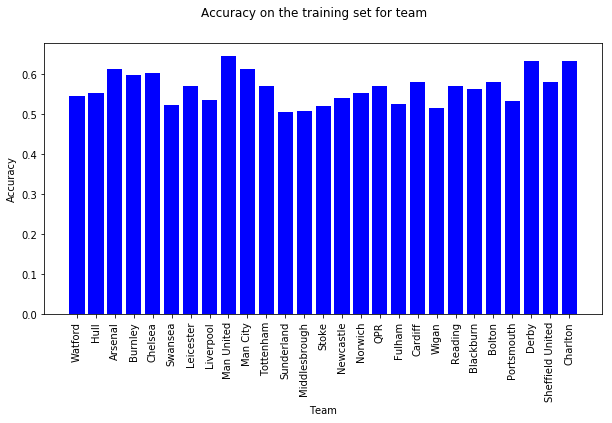

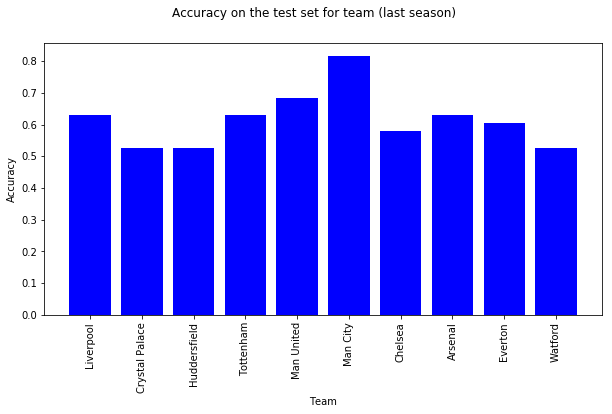

In [60]:
def find_team(team_code):
    for k, v in teams_code.items():
        if v == team_code:
            return k
    return None


df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_copy1['HomeTeam']):
    df_test1 = df_copy1[(df_copy1.HomeTeam == team) | (df_copy1.AwayTeam == team)]
    
    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.5:
        teams_with_high_accuracy.append(team)
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the training set for team')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.5:
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the test set for team (last season)')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

In [20]:
df_copy = df.copy()
df_copy = df_copy[df_copy.MW >4]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = df_copy[(df_copy.HomeTeam.isin(teams_with_high_accuracy)) | (df_copy.AwayTeam.isin(teams_with_high_accuracy))]

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

y_train = df_copy1.loc[380:]['FTR']
y_validation = df_test.loc[0:379]['FTR']

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.466029
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458852
[2]	validation_0-merror:0.459091
[3]	validation_0-merror:0.460287
[4]	validation_0-merror:0.459809
[5]	validation_0-merror:0.45933
[6]	validation_0-merror:0.457416
[7]	validation_0-merror:0.460287
[8]	validation_0-merror:0.456699
[9]	validation_0-merror:0.459091
[10]	validation_0-merror:0.458373
[11]	validation_0-merror:0.457895
[12]	validation_0-merror:0.457655
[13]	validation_0-merror:0.456699
[14]	validation_0-merror:0.45622
[15]	validation_0-merror:0.456459
[16]	validation_0-merror:0.454785
[17]	validation_0-merror:0.455024
[18]	validation_0-merror:0.45622
[19]	validation_0-merror:0.45622
[20]	validation_0-merror:0.455981
[21]	validation_0-merror:0.455981
[22]	validation_0-merror:0.455263
[23]	validation_0-merror:0.455742
[24]	validation_0-merror:0.456459
[25]	validation_0-merror:0.45622
[26]	validation_0-merror:0.457655
[27]	validation_0-merror:0.457

[0]	validation_0-merror:0.44805	validation_1-merror:0.437931
[1]	validation_0-merror:0.442357	validation_1-merror:0.437931
[2]	validation_0-merror:0.440649	validation_1-merror:0.424138
[3]	validation_0-merror:0.439795	validation_1-merror:0.427586
[4]	validation_0-merror:0.440649	validation_1-merror:0.431034
[5]	validation_0-merror:0.439226	validation_1-merror:0.434483
[6]	validation_0-merror:0.437518	validation_1-merror:0.431034
[7]	validation_0-merror:0.438941	validation_1-merror:0.431034
[8]	validation_0-merror:0.437518	validation_1-merror:0.427586
[9]	validation_0-merror:0.44008	validation_1-merror:0.441379
[10]	validation_0-merror:0.438941	validation_1-merror:0.441379
[11]	validation_0-merror:0.437802	validation_1-merror:0.444828
[12]	validation_0-merror:0.437802	validation_1-merror:0.441379
[13]	validation_0-merror:0.437518	validation_1-merror:0.441379
[14]	validation_0-merror:0.436664	validation_1-merror:0.437931
[15]	validation_0-merror:0.437233	validation_1-merror:0.434483
[16]

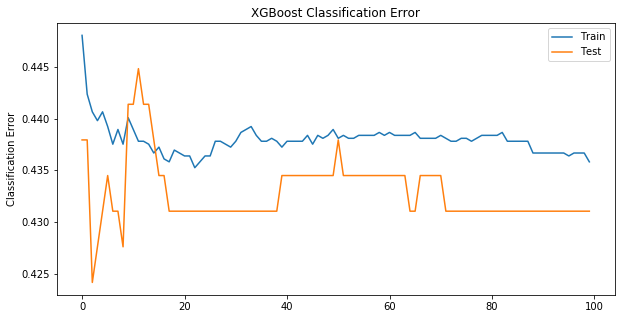

In [21]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

[0]	validation_0-merror:0.461722
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.461962
[2]	validation_0-merror:0.461962
[3]	validation_0-merror:0.458134
[4]	validation_0-merror:0.457655
[5]	validation_0-merror:0.458612
[6]	validation_0-merror:0.459569
[7]	validation_0-merror:0.457416
[8]	validation_0-merror:0.458852
[9]	validation_0-merror:0.457177
[10]	validation_0-merror:0.457416
[11]	validation_0-merror:0.457177
[12]	validation_0-merror:0.45622
[13]	validation_0-merror:0.456938
[14]	validation_0-merror:0.457177
[15]	validation_0-merror:0.457895
[16]	validation_0-merror:0.457895
[17]	validation_0-merror:0.458612
[18]	validation_0-merror:0.457655
[19]	validation_0-merror:0.457655
[20]	validation_0-merror:0.457177
[21]	validation_0-merror:0.456938
[22]	validation_0-merror:0.457177
Stopping. Best iteration:
[12]	validation_0-merror:0.45622



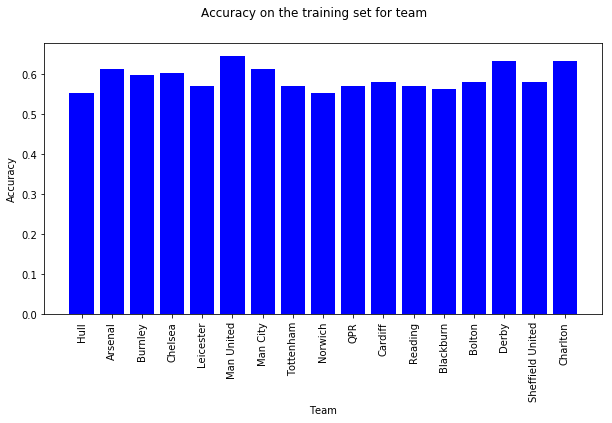

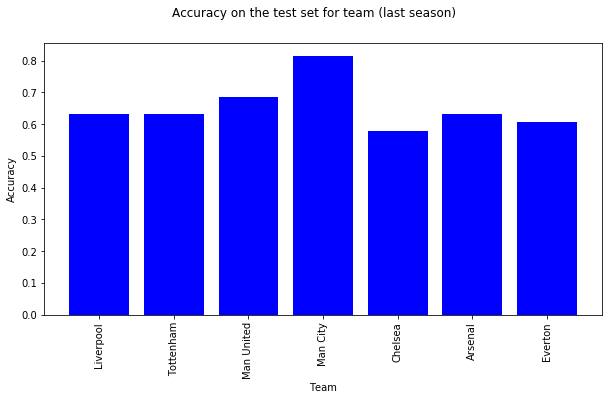

In [69]:
def find_team(team_code):
    for k, v in teams_code.items():
        if v == team_code:
            return k
    return None


df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_copy1['HomeTeam']):
    df_test1 = df_copy1[(df_copy1.HomeTeam == team) | (df_copy1.AwayTeam == team)]
    
    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.55:
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the training set for team')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.55:
        teams_with_high_accuracy.append(team)
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the test set for team (last season)')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

In [70]:
df_copy = df.copy()
df_copy = df_copy[df_copy.MW >5]
df_copy = df_copy[df_copy.MW <32]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = df_copy[(df_copy.HomeTeam.isin(teams_with_high_accuracy)) | (df_copy.AwayTeam.isin(teams_with_high_accuracy))]

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

y_train = df_copy1.loc[380:]['FTR']
y_validation = df_test.loc[0:379]['FTR']

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.470335
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.464833
[2]	validation_0-merror:0.466268
[3]	validation_0-merror:0.466029
[4]	validation_0-merror:0.467703
[5]	validation_0-merror:0.466268
[6]	validation_0-merror:0.46866
[7]	validation_0-merror:0.46866
[8]	validation_0-merror:0.466507
[9]	validation_0-merror:0.466268
[10]	validation_0-merror:0.466746
[11]	validation_0-merror:0.467225
[12]	validation_0-merror:0.467464
[13]	validation_0-merror:0.465311
[14]	validation_0-merror:0.464593
[15]	validation_0-merror:0.464833
[16]	validation_0-merror:0.466507
[17]	validation_0-merror:0.467464
[18]	validation_0-merror:0.466746
[19]	validation_0-merror:0.467464
[20]	validation_0-merror:0.466268
[21]	validation_0-merror:0.466029
[22]	validation_0-merror:0.462679
[23]	validation_0-merror:0.465072
[24]	validation_0-merror:0.465789
[25]	validation_0-merror:0.465789
[26]	validation_0-merror:0.465072
[27]	validation_0-merror:0.

In [54]:
df_copy = df.copy()
df_copy = df_copy[df_copy.MW >4]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = df_copy[(df_copy.HomeTeam.isin(teams_with_high_accuracy)) | (df_copy.AwayTeam.isin(teams_with_high_accuracy))]

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

y_train = df_copy1.loc[380:]['FTR']
y_validation = df_test.loc[0:379]['FTR']

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9438666971191386, gamma= 6, min_child_weight= 15, 
                               colsample_bytree= 0.9946873453538718, max_depth= 3,learning_rate=0.0872881726384608,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.322953
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.311396
[2]	validation_0-merror:0.305939
[3]	validation_0-merror:0.304976
[4]	validation_0-merror:0.297913
[5]	validation_0-merror:0.296629
[6]	validation_0-merror:0.297913
[7]	validation_0-merror:0.290851
[8]	validation_0-merror:0.291172
[9]	validation_0-merror:0.290851
[10]	validation_0-merror:0.290209
[11]	validation_0-merror:0.289888
[12]	validation_0-merror:0.290209
[13]	validation_0-merror:0.291493
[14]	validation_0-merror:0.292777
[15]	validation_0-merror:0.291172
[16]	validation_0-merror:0.287961
[17]	validation_0-merror:0.286998
[18]	validation_0-merror:0.285393
[19]	validation_0-merror:0.286356
[20]	validation_0-merror:0.285072
[21]	validation_0-merror:0.28443
[22]	validation_0-merror:0.285072
[23]	validation_0-merror:0.28443
[24]	validation_0-merror:0.284109
[25]	validation_0-merror:0.282504
[26]	validation_0-merror:0.282504
[27]	validation_0-merror:0.

In [22]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
y_validation = df_test['FTR']

Optimal number of features: 96
Selected features: ['AF5', 'AGD10', 'AGD10w', 'AGD20', 'AGD20w', 'AGD30', 'AGD30w', 'AGD38', 'AGD5w', 'AGL10w', 'AGL20', 'AGL20w', 'AGL30', 'AGL30w', 'AGL38', 'AGL38w', 'AGL5', 'AGL5w', 'AGS10', 'AGS10w', 'AGS20', 'AGS20w', 'AGS30', 'AGS30w', 'AGS38', 'AGS5', 'AGS5w', 'ALM1', 'AP10', 'AP10w', 'AP20', 'AP20w', 'AP30w', 'AP38', 'AP38w', 'AP5', 'AP5w', 'AwayTeam', 'DP10', 'DP10w', 'DP20', 'DP20w', 'DP30', 'DP30w', 'DP38', 'DP38w', 'DP5', 'DP5w', 'DPB10', 'DPB10w', 'DPB20', 'DPB20w', 'DPB5', 'DPB5w', 'Day', 'DaysFromToday', 'GD10', 'GD10w', 'GD20', 'GD20w', 'GD30w', 'GD38', 'GD38w', 'GD5', 'GD5w', 'HF5', 'HGD10w', 'HGD20', 'HGD20w', 'HGD30', 'HGD30w', 'HGD5w', 'HGL20w', 'HGL30w', 'HGL38w', 'HGL5w', 'HGS20w', 'HGS30', 'HGS38', 'HGS38w', 'HGS5', 'HGS5w', 'HLF5', 'HLM4', 'HP10', 'HP10w', 'HP20', 'HP30w', 'HP38w', 'HP5', 'HP5w', 'HomeTeam', 'LFD5', 'LSTPA', 'LSTPD', 'LSTPH']
XGBClassifier average accuracy for cross-validation test set is 0.705


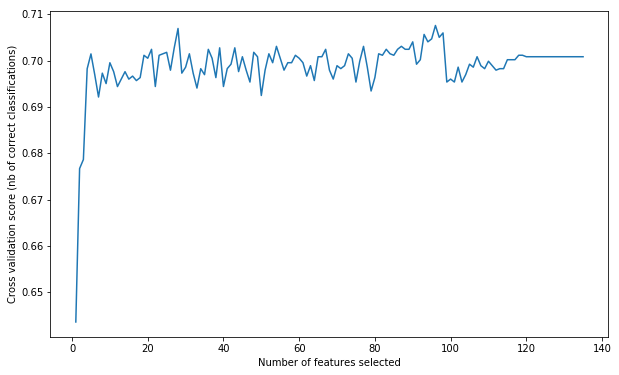

In [23]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [77]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]


parameters = {  
    "min_child_weight": st.randint(0, 20),
    "gamma": st.randint(0, 10),
    "subsample": st.beta(10, 1),
    "colsample_bytree": st.beta(10, 1),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.5)
}

fit_params={'early_stopping_rounds':10, 
            'eval_set': [[X, y]]}


classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    gs = RandomizedSearchCV(classifier,param_distributions =parameters,fit_params=fit_params,cv=10,n_jobs=-1,n_iter=250, verbose=10)  
    gs.fit(X, y)  
    
print (gs.best_score_, gs.best_params_) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

0.7168539325842697 {'colsample_bytree': 0.9880016475545704, 'gamma': 8, 'learning_rate': 0.06710039688496273, 'max_depth': 9, 'min_child_weight': 12, 'subsample': 0.8057006602666088}


In [24]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

In [25]:
classifier = xgb.XGBClassifier(subsample=0.7986877756118743, gamma= 5, min_child_weight= 19, 
                               colsample_bytree= 0.9688810212379039, max_depth= 3,learning_rate=0.05776221111719017,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-error:0.285714
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.278973
[2]	validation_0-error:0.273836
[3]	validation_0-error:0.273836
[4]	validation_0-error:0.273194
[5]	validation_0-error:0.269342
[6]	validation_0-error:0.268379
[7]	validation_0-error:0.268379
[8]	validation_0-error:0.269021
[9]	validation_0-error:0.270947
[10]	validation_0-error:0.2687
[11]	validation_0-error:0.266132
[12]	validation_0-error:0.264848
[13]	validation_0-error:0.265169
[14]	validation_0-error:0.264848
[15]	validation_0-error:0.265169
[16]	validation_0-error:0.264205
[17]	validation_0-error:0.262921
[18]	validation_0-error:0.262921
[19]	validation_0-error:0.2626
[20]	validation_0-error:0.262279
[21]	validation_0-error:0.261637
[22]	validation_0-error:0.259069
[23]	validation_0-error:0.260674
[24]	validation_0-error:0.259711
[25]	validation_0-error:0.259711
[26]	validation_0-error:0.259711
[27]	validation_0-error:0.259711
[28]	validation_0-error:

[0]	validation_0-error:0.285714
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.278973
[2]	validation_0-error:0.273836
[3]	validation_0-error:0.273836
[4]	validation_0-error:0.273194
[5]	validation_0-error:0.269342
[6]	validation_0-error:0.268379
[7]	validation_0-error:0.268379
[8]	validation_0-error:0.269021
[9]	validation_0-error:0.270947
[10]	validation_0-error:0.2687
[11]	validation_0-error:0.266132
[12]	validation_0-error:0.264848
[13]	validation_0-error:0.265169
[14]	validation_0-error:0.264848
[15]	validation_0-error:0.265169
[16]	validation_0-error:0.264205
[17]	validation_0-error:0.262921
[18]	validation_0-error:0.262921
[19]	validation_0-error:0.2626
[20]	validation_0-error:0.262279
[21]	validation_0-error:0.261637
[22]	validation_0-error:0.259069
[23]	validation_0-error:0.260674
[24]	validation_0-error:0.259711
[25]	validation_0-error:0.259711
[26]	validation_0-error:0.259711
[27]	validation_0-error:0.259711
[28]	validation_0-error:

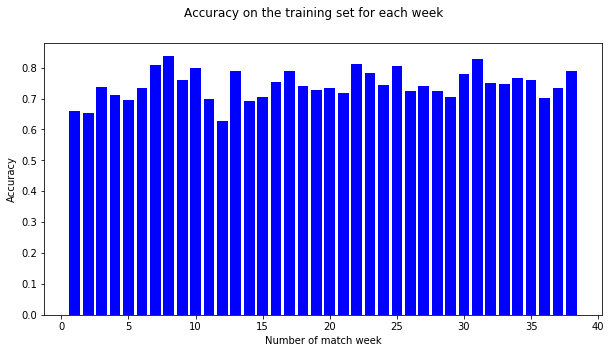

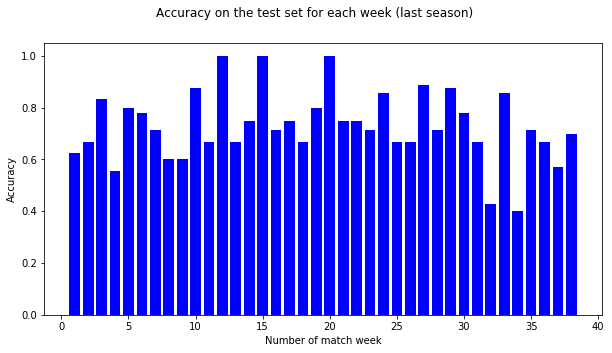

In [30]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.7986877756118743, gamma= 5, min_child_weight= 19, 
                               colsample_bytree= 0.9688810212379039, max_depth= 3,learning_rate=0.05776221111719017,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_copy1[df_copy1.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  

# plt.plot(dff.loc[0],dff.loc[1],color='blue')
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Accuracy on the training set for each week')
plt.xlabel('Number of match week')
plt.ylabel('Accuracy')
plt.show()
    
weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_test[df_test.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  
# plt.plot(dff.loc[0],dff.loc[1],color='blue')
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Accuracy on the test set for each week (last season)')
plt.xlabel('Number of match week')
plt.ylabel('Accuracy')
plt.show()

[0]	validation_0-error:0.285714
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.278973
[2]	validation_0-error:0.273836
[3]	validation_0-error:0.273836
[4]	validation_0-error:0.273194
[5]	validation_0-error:0.269342
[6]	validation_0-error:0.268379
[7]	validation_0-error:0.268379
[8]	validation_0-error:0.269021
[9]	validation_0-error:0.270947
[10]	validation_0-error:0.2687
[11]	validation_0-error:0.266132
[12]	validation_0-error:0.264848
[13]	validation_0-error:0.265169
[14]	validation_0-error:0.264848
[15]	validation_0-error:0.265169
[16]	validation_0-error:0.264205
[17]	validation_0-error:0.262921
[18]	validation_0-error:0.262921
[19]	validation_0-error:0.2626
[20]	validation_0-error:0.262279
[21]	validation_0-error:0.261637
[22]	validation_0-error:0.259069
[23]	validation_0-error:0.260674
[24]	validation_0-error:0.259711
[25]	validation_0-error:0.259711
[26]	validation_0-error:0.259711
[27]	validation_0-error:0.259711
[28]	validation_0-error:

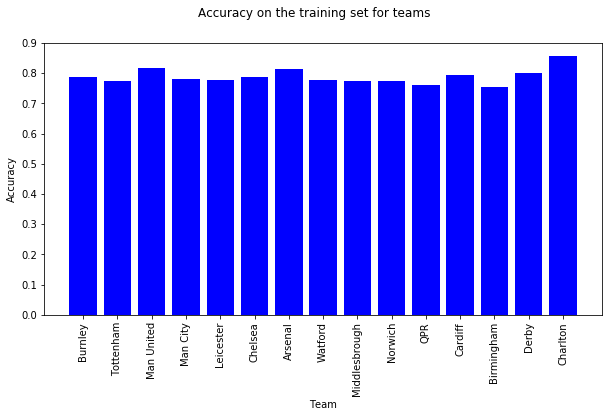

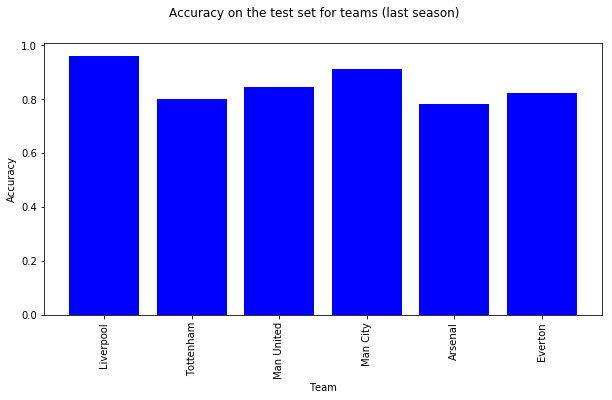

In [43]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.7986877756118743, gamma= 5, min_child_weight= 19, 
                               colsample_bytree= 0.9688810212379039, max_depth= 3,learning_rate=0.05776221111719017,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])


teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_copy['HomeTeam']):
    df_test1 = df_copy1[(df_copy1.HomeTeam == team) | (df_copy.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.75:
        teams_with_high_accuracy.append(team)
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the training set for teams')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.75:
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the test set for teams (last season)')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

In [44]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy[df_copy.MW > 4]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

df_test = df_test[(df_test.HomeTeam.isin(teams_with_high_accuracy)) | (df_test.AwayTeam.isin(teams_with_high_accuracy))]

y_train = df_copy.loc[380:]['FTR']
y_validation = df_test['FTR']

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.7986877756118743, gamma= 5, min_child_weight= 19, 
                               colsample_bytree= 0.9688810212379039, max_depth= 3,learning_rate=0.05776221111719017,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-error:0.296308
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.282504
[2]	validation_0-error:0.282825
[3]	validation_0-error:0.282504
[4]	validation_0-error:0.280257
[5]	validation_0-error:0.279936
[6]	validation_0-error:0.279615
[7]	validation_0-error:0.278652
[8]	validation_0-error:0.279615
[9]	validation_0-error:0.276405
[10]	validation_0-error:0.277047
[11]	validation_0-error:0.277047
[12]	validation_0-error:0.277368
[13]	validation_0-error:0.274478
[14]	validation_0-error:0.275441
[15]	validation_0-error:0.276405
[16]	validation_0-error:0.27512
[17]	validation_0-error:0.275441
[18]	validation_0-error:0.275441
[19]	validation_0-error:0.275762
[20]	validation_0-error:0.274799
[21]	validation_0-error:0.274478
[22]	validation_0-error:0.274157
[23]	validation_0-error:0.273194
[24]	validation_0-error:0.273515
[25]	validation_0-error:0.272552
[26]	validation_0-error:0.272552
[27]	validation_0-error:0.271268
[28]	validation_0-err

[0]	validation_0-error:0.285714
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.278973
[2]	validation_0-error:0.273836
[3]	validation_0-error:0.273836
[4]	validation_0-error:0.273194
[5]	validation_0-error:0.269342
[6]	validation_0-error:0.268379
[7]	validation_0-error:0.268379
[8]	validation_0-error:0.269021
[9]	validation_0-error:0.270947
[10]	validation_0-error:0.2687
[11]	validation_0-error:0.266132
[12]	validation_0-error:0.264848
[13]	validation_0-error:0.265169
[14]	validation_0-error:0.264848
[15]	validation_0-error:0.265169
[16]	validation_0-error:0.264205
[17]	validation_0-error:0.262921
[18]	validation_0-error:0.262921
[19]	validation_0-error:0.2626
[20]	validation_0-error:0.262279
[21]	validation_0-error:0.261637
[22]	validation_0-error:0.259069
[23]	validation_0-error:0.260674
[24]	validation_0-error:0.259711
[25]	validation_0-error:0.259711
[26]	validation_0-error:0.259711
[27]	validation_0-error:0.259711
[28]	validation_0-error:

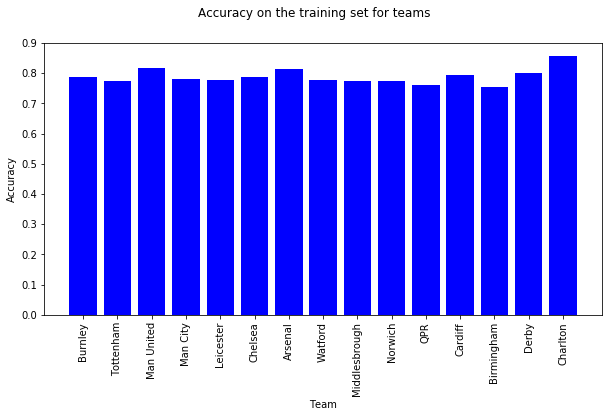

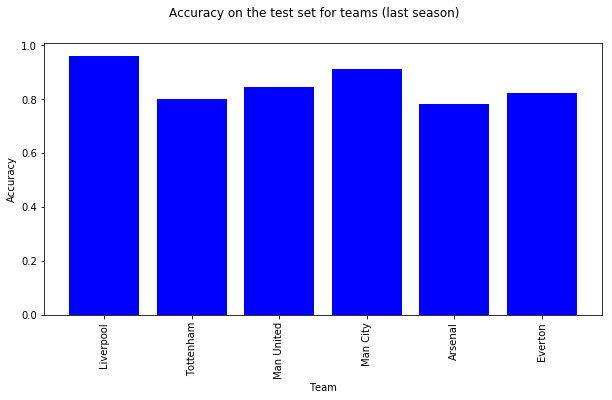

In [52]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.7986877756118743, gamma= 5, min_child_weight= 19, 
                               colsample_bytree= 0.9688810212379039, max_depth= 3,learning_rate=0.05776221111719017,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])


teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_copy['HomeTeam']):
    df_test1 = df_copy1[(df_copy1.HomeTeam == team) | (df_copy.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.75:
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the training set for teams')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.75:
        teams_with_high_accuracy.append(team)
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Accuracy on the test set for teams (last season)')
plt.xlabel('Team')
plt.ylabel('Accuracy')
plt.show()

In [53]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy[df_copy.MW > 4]
df_copy = df_copy[df_copy.MW < 32]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

df_test = df_test[(df_test.HomeTeam.isin(teams_with_high_accuracy)) | (df_test.AwayTeam.isin(teams_with_high_accuracy))]

y_train = df_copy.loc[380:]['FTR']
y_validation = df_test['FTR']

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.7986877756118743, gamma= 5, min_child_weight= 19, 
                               colsample_bytree= 0.9688810212379039, max_depth= 3,learning_rate=0.05776221111719017,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-error:0.299839
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.285072
[2]	validation_0-error:0.288283
[3]	validation_0-error:0.282825
[4]	validation_0-error:0.282504
[5]	validation_0-error:0.28122
[6]	validation_0-error:0.279936
[7]	validation_0-error:0.279294
[8]	validation_0-error:0.280899
[9]	validation_0-error:0.280257
[10]	validation_0-error:0.280257
[11]	validation_0-error:0.280578
[12]	validation_0-error:0.281541
[13]	validation_0-error:0.280578
[14]	validation_0-error:0.282825
[15]	validation_0-error:0.279294
[16]	validation_0-error:0.27801
[17]	validation_0-error:0.279615
[18]	validation_0-error:0.279615
[19]	validation_0-error:0.278331
[20]	validation_0-error:0.276405
[21]	validation_0-error:0.274478
[22]	validation_0-error:0.27512
[23]	validation_0-error:0.274157
[24]	validation_0-error:0.275441
[25]	validation_0-error:0.276083
[26]	validation_0-error:0.276405
[27]	validation_0-error:0.276405
[28]	validation_0-error